In [128]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 0. Precurser Info
## 0.a Credits
* This is my first competition on Kaggle
* For resources, I used:
    * [Alexis Cook Titanic Tutoria Walkthrough](https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook)
    * [Ken Jee Tutorial Video](https://www.youtube.com/watch?v=I3FBJdiExcg])
    * A numer of articles on stack overflow, kaggle, and some sparring with ChatGPT 4o in the moments where the logic / reasoning was not completely clear to me =)
## 0.b Variable Descriptions
* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	male, female
* Age	Age in years
* sibsp	# of siblings / spouses aboard the Titanic
* parch	# of parents / children aboard the Titanic
* ticket	Ticket number
* fare	Passenger fare
* cabin	Cabin number
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

## 0.b Additional Import Statements

In [129]:
from sklearn.ensemble import RandomForestClassifier #in order to use a random forest classification tree
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# 1.a Import Training and Testing Data

In [130]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data.head() #just figured out that excluding the print statement shows a more legible than using the print() output

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1.b Training Data Exploration

In [131]:
train_data.info()
#Age and Cabin have quite a few null values, and Embarked as 2 missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [132]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 2. Example Case: Outcome Model based on Gender

In [133]:
women = train_data.loc[train_data.Sex == 'female']['Survived']
rate_women = np.round(100*sum(women)/len(women),3)

print(f'{rate_women}% of women survived the titanic incident')

men = train_data.loc[train_data.Sex == 'male']['Survived']
rate_men = np.round(100*sum(men)/len(men),3)

print(f'{rate_men}% of men survived the titanic incident')

74.204% of women survived the titanic incident
18.891% of men survived the titanic incident


# 3. Example Case: Outcome Model based on Pclass, Sex, SibSp, Parch

In [134]:
y = train_data['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators = 100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('submission successfully saved... but to where... found it =)')

submission successfully saved... but to where... found it =)


# 4. Case: Outcome Model based on Pclass, Sex, SibSp, Parch, Embarked

In [135]:
#Quick check for variables that may be missing data in one form or another (Age, Cabin and Embarked each may require soem adjusting to use)

#Train Data NaN values / missing values
print('Training Data Status')
print(train_data.isna().sum())
print()

#Test Data NaN values / missing values
print('Test Data Status')
print(test_data.isna().sum())

Training Data Status
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Data Status
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [136]:
train_data_2 = train_data.dropna(subset=['Embarked'], how='all')
print(train_data_2.info())
y = train_data_2['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
X = pd.get_dummies(train_data_2[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=1) #Traying at estimators=200 for next submission
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print('done... again')

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB
None
done... again


# 5.a Case: Outcome based on expanded feature engineering set (Ken Jee example based)
* Will use Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, cabin_count, Cabin_Letter, numeric_ticket, name_title

In [137]:
training = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

#train_test is a classifier for splitting the dataset out after the additional variables and dummy encoding are done 
training['train_test'] = 1 #Set to 1 for training data
test['train_test'] = 0 #Set to 0 for test data
test['Survived'] = np.NaN #Test data does not include a Survived column, so have to add in manually prior to concat
all_data = pd.concat([training,test])

#%matplotlib inline #maybe not necessary, but recommended in the tutorial
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'], dtype='object')

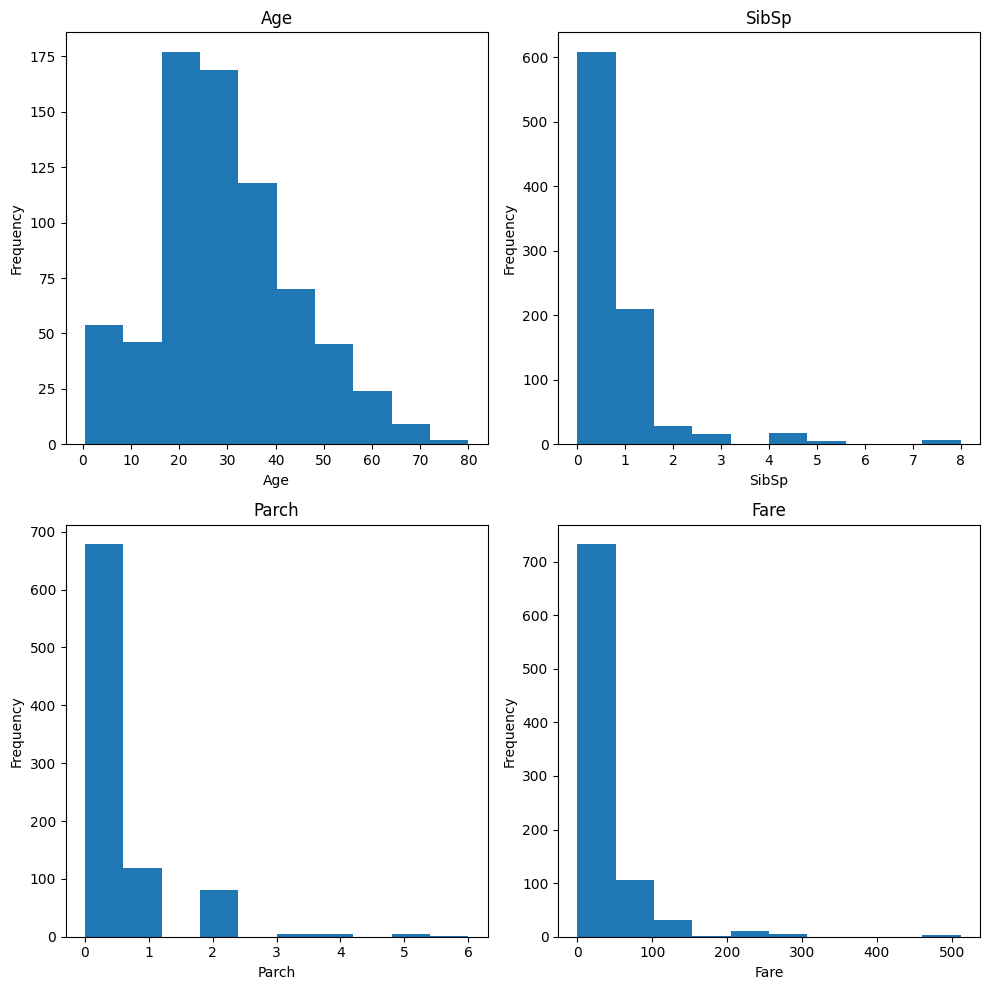

In [138]:
# Splitting columns up by numeric and categorical
# Checking the distribution of all numeric columns first
df_num = training[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = training[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    axes[i].hist(df_num[col].dropna())
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<Axes: >

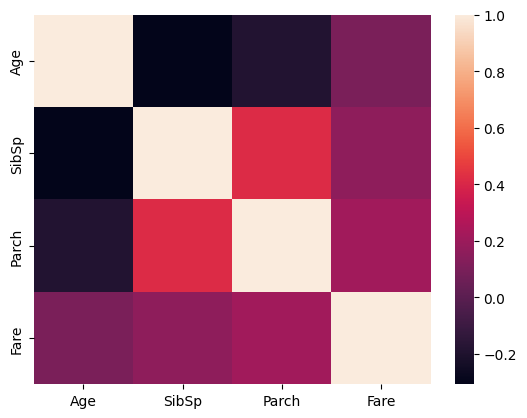

In [139]:
print(df_num.corr())
sns.heatmap(df_num.corr())

In [140]:
#Pivot table showing mean values for categories against Survival index
pd.pivot_table(training, index=['Survived'], values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


<Figure size 640x480 with 0 Axes>

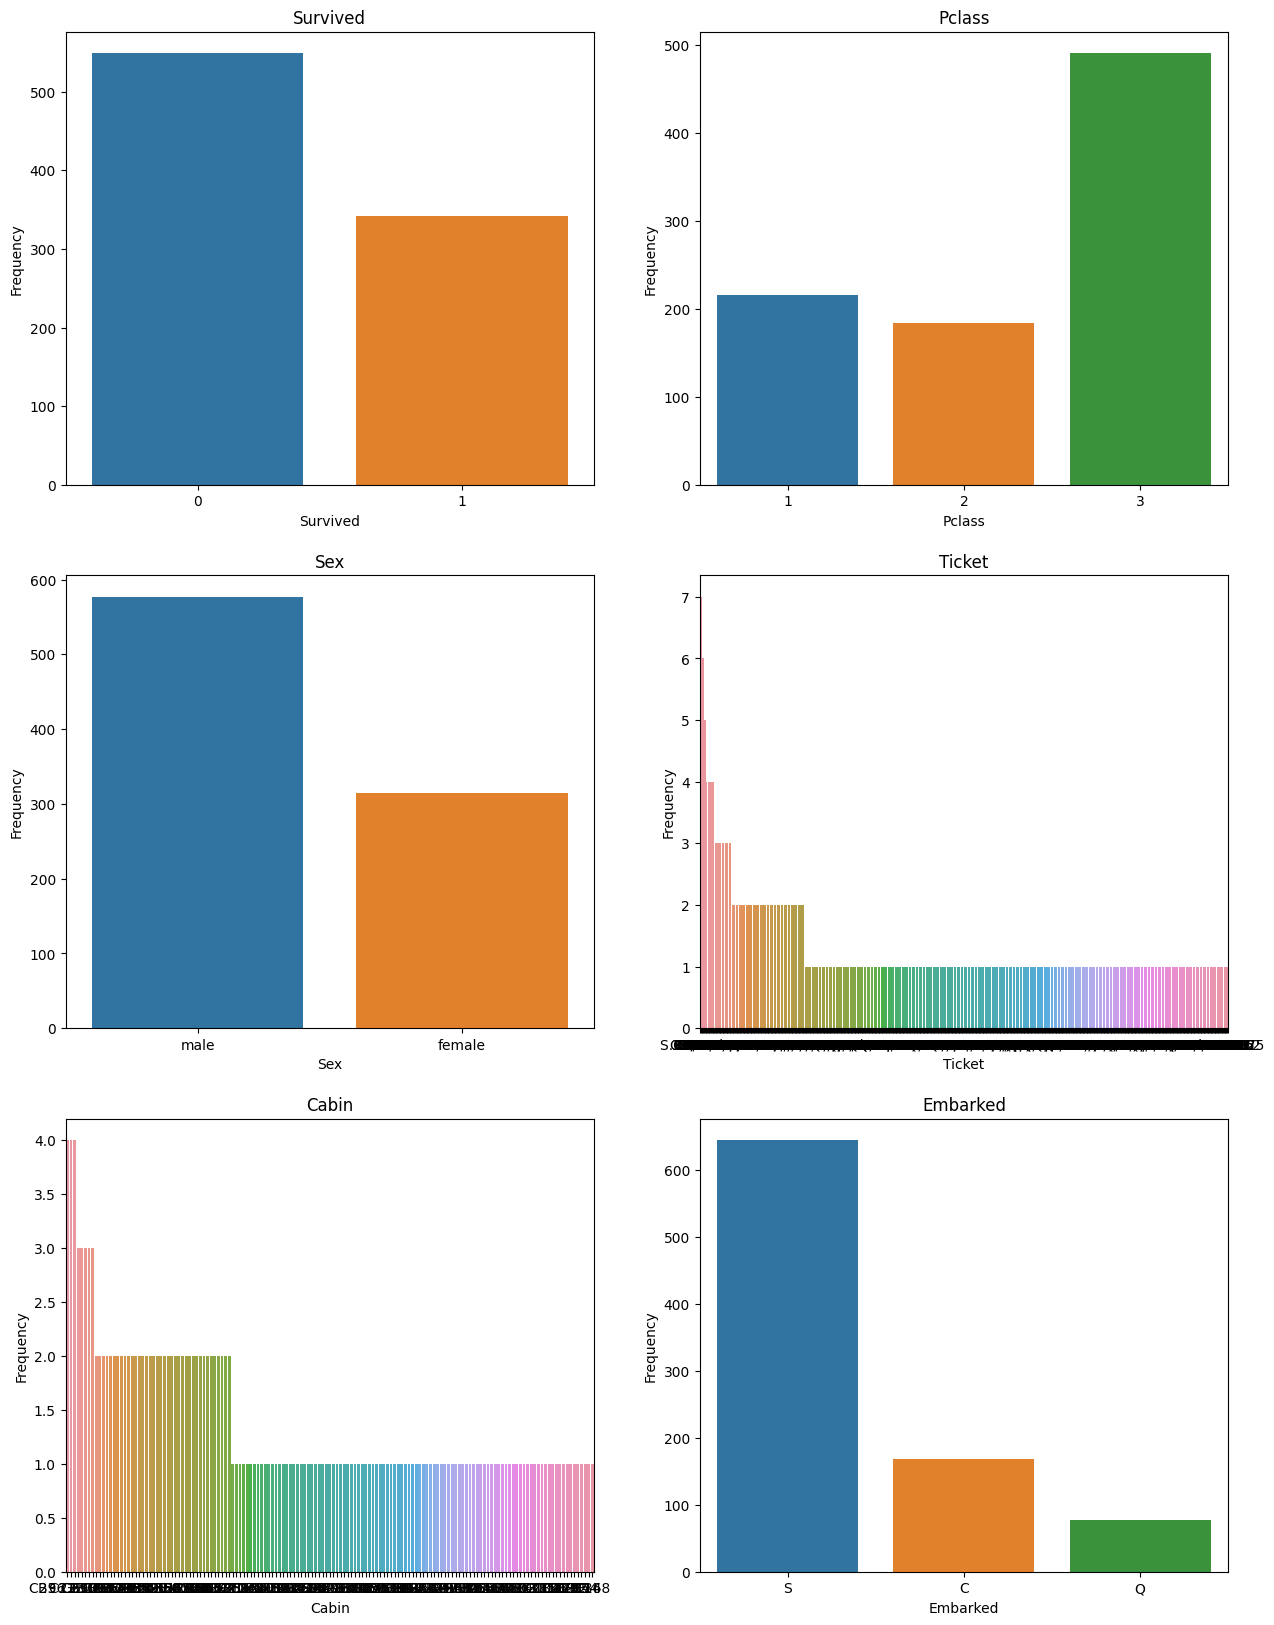

In [141]:
#Checking categorical variables for basic distribution
plt.clf()

fig, axes = plt.subplots(3,2,figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(df_cat.columns):
    value_counts = df_cat[col].value_counts()
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [col, 'Frequency']  # Rename columns for clarity
    
    sns.barplot(x=value_counts_df[col], y=value_counts_df['Frequency'], ax=axes[i])
    axes[i].set_title(col)  # Set title
    axes[i].set_xlabel(col)  # Set x-axis label
    axes[i].set_ylabel('Frequency')  # Set y-axis label

#plt.tight_layout()
plt.show()

In [142]:
# Comparing survival vs categorical variables 
pclass_pivot = pd.pivot_table(training, index='Survived', columns='Pclass', values='Ticket', aggfunc='count', margins=True, margins_name='Total')
sex_pivot = pd.pivot_table(training, index='Survived', columns='Sex', values='Ticket', aggfunc='count', margins=True, margins_name='Total')
embarked_pivot = pd.pivot_table(training, index='Survived', columns='Embarked', values='Ticket', aggfunc='count', margins=True, margins_name='Total')

total_count = pclass_pivot.loc['Total', 'Total']

pclass_pivot_perc = (pclass_pivot / total_count * 100).round(1)
sex_pivot_perc = (sex_pivot / total_count * 100).round(1)
embarked_pivot_perc = (embarked_pivot / total_count * 100).round(1)

print(pclass_pivot_perc)
print()
print(sex_pivot_perc)
print()
print(embarked_pivot_perc)

Pclass       1     2     3  Total
Survived                         
0          9.0  10.9  41.8   61.6
1         15.3   9.8  13.4   38.4
Total     24.2  20.7  55.1  100.0

Sex       female  male  Total
Survived                     
0            9.1  52.5   61.6
1           26.2  12.2   38.4
Total       35.2  64.8  100.0

Embarked     C    Q     S  Total
Survived                        
0          8.4  5.3  47.9   61.6
1         10.4  3.4  24.4   38.2
Total     18.9  8.6  72.3   99.8


In [143]:
#Checking cabin count for passengers to see if there is any indication of survival advantage
training['cabin_count'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
print(training.cabin_count.value_counts())

cabin_count_pivot = pd.pivot_table(training, index='Survived', columns='cabin_count', values='Ticket', margins=True, aggfunc='count', margins_name = 'Total')
cabin_count_pivot_perc = (cabin_count_pivot / total_count * 100).round(1)
print(cabin_count_pivot_perc)

cabin_count
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64
cabin_count     0     1    2    3    4  Total
Survived                                     
0            54.0   6.5  0.8  0.3  NaN   61.6
1            23.1  13.7  1.0  0.3  0.2   38.4
Total        77.1  20.2  1.8  0.7  0.2  100.0


In [144]:
training['cabin_letter'] = training.Cabin.apply(lambda x: str(x)[0])
print(training.cabin_letter.value_counts())
#n will stand for n/a in this case

cabin_letter_pivot = pd.pivot_table(training, index='Survived', columns='cabin_letter', values='Ticket', margins=True, aggfunc='count', margins_name='Total')
cabin_letter_pivot_perc = (cabin_letter_pivot / total_count * 100).round(1)
print(cabin_letter_pivot_perc)

#null values here may be useful as a feature from a category perspective, but not confirmed yet

cabin_letter
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64
cabin_letter    A    B    C    D    E    F    G    T     n  Total
Survived                                                         
0             0.9  1.3  2.7  0.9  0.9  0.6  0.2  0.1  54.0   61.6
1             0.8  3.9  3.9  2.8  2.7  0.9  0.2  NaN  23.1   38.4
Total         1.7  5.3  6.6  3.7  3.6  1.5  0.4  0.1  77.1  100.0


In [145]:
#This code will add some properties to the ticket values through additional fields

#identifies if the ticket number is only numeric
training['numeric_ticket'] = training['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)

#creates unique strings based on letters available in ticket variable
#joins elements of a split together (excluding last element of the split) and replaces characters to form a complete list of letters at the start of the ticket
training['ticket_letters'] = training['Ticket'].apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')) > 0 else 0)
print(training['numeric_ticket'].value_counts())
print(training['ticket_letters'].value_counts())

numeric_ticket_pivot = pd.pivot_table(training, index='Survived', columns = 'numeric_ticket', values='Ticket', aggfunc='count', margins=True, margins_name='Total')
print(numeric_ticket_pivot)

numeric_ticket
1    661
0    230
Name: count, dtype: int64
ticket_letters
           665
pc          60
ca          41
a5          21
stono2      18
          ... 
scow         1
fa           1
sop          1
sca4         1
casoton      1
Name: count, Length: 29, dtype: int64
numeric_ticket    0    1  Total
Survived                       
0               142  407    549
1                88  254    342
Total           230  661    891


In [146]:
training['Name'].head(10)
training['name_title'] = training['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip()) #will give mr, mrs, ms, ets
print(training.name_title.value_counts())

#Code to help the text display without truncation / wrapping
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

name_title_pivot = pd.pivot_table(training, index='Survived', columns='name_title', values='Ticket', aggfunc='count', margins=True, margins_name='Total')
print(name_title_pivot)

name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64
name_title  Capt  Col  Don   Dr  Jonkheer  Lady  Major  Master   Miss  Mlle  Mme     Mr    Mrs   Ms  Rev  Sir  the Countess  Total
Survived                                                                                                                          
0            1.0  1.0  1.0  4.0       1.0   NaN    1.0    17.0   55.0   NaN  NaN  436.0   26.0  NaN  6.0  NaN           NaN    549
1            NaN  1.0  NaN  3.0       NaN   1.0    1.0    23.0  127.0   2.0  1.0   81.0   99.0  1.0  NaN  1.0           1.0    342
Total        1.0  2.0  1.0  7.0       1.0   1.0    2.0    40.0  182.0   2.0  1.0  517.0  125.0  1.0

In [147]:
#create all the same feature variables in the train_data test set from section 1.b
all_data['cabin_count'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_letter'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data['Ticket'].apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')) > 0 else 0)
all_data['name_title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

#impute nulls for continuous data fields (in test and training data)
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())

#drop nulls for Embarked field (not required for test data, no nulls)
all_data.dropna(subset=['Embarked'], inplace=True)

#normalizing fare to make it work better with prediction model
all_data['norm_fare'] = np.log(all_data.Fare+1)

#convert pclass to string to allow for categorical encoding with pd.get_dummies
all_data['Pclass'] = all_data['Pclass'].astype(str)

#get dummies for categorical variables
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_letter', 'cabin_count', 'numeric_ticket', 'name_title', 'train_test']])
X_train = all_dummies[all_dummies['train_test'] == 1].drop(['train_test'], axis=1) #1 for training
X_test = all_dummies[all_dummies['train_test'] == 0].drop(['train_test'], axis=1) #0 for test

In [148]:
#scaled data
pd.set_option('display.max_rows', 20)

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']] = scale.fit_transform(all_dummies_scaled[['Age', 'SibSp', 'Parch', 'norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled['train_test'] == 1].drop(['train_test'], axis=1) #1 for training
X_test_scaled = all_dummies_scaled[all_dummies_scaled['train_test'] == 0].drop(['train_test'], axis=1) #0 for test

y_train = all_data[all_data['train_test'] == 1]['Survived']
y_train.shape

(889,)

In [149]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier already imported
from sklearn.svm import SVC
from xgboost import XGBClassifier

Results of cross validation testing

* GaussianNB Val Score: 72.22%
* Logistic Regression (No Scaling) Val Score: 82.23%
* Logistic Regression (With Scaling) Val Score: 82.23%
* Decision Tree (No Scaling) Val Score: 77.73%
* Decision Tree (With Scaling) Val Score: 77.73%
* K Nearest Neighbors (No Scaling) Val Score: 80.99%
* K Nearest Neighbors (With Scaling) Val Score: 81.44%
* Random Forest (No Scaling) Val Score: 80.21%
* Random Forest (With Scaling) Val Score: 80.09%
* Support Vector Classifier (With Scaling) Val Score: 83.36%
* Extreme Gradient Boosing (With Scaling) Val Score: 81.1%

End result from voting model
* Voting Classification (with Scaling) Val Score: 82.45%

In [150]:
# Naive Bayes Cross Validation
gnb = GaussianNB()
cv = cross_val_score(gnb, X_train_scaled, y_train, cv=5)
print(cv)
print('GaussianNB Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
GaussianNB Val Score: 72.22%


In [151]:
# Logistic Regression (No Scaling) Cross Validation
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train, y_train, cv=5)
print(cv)
print('Logistic Regression (No Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
Logistic Regression (No Scaling) Val Score: 82.23%


In [152]:
# Logistic Regression (With Scaling) Cross Validation
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print(cv)
print('Logistic Regression (With Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
Logistic Regression (With Scaling) Val Score: 82.23%


In [153]:
# Decision Train (No Scaling) Cross Validation
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train, y_train, cv=5)
print(cv)
print('Decision Tree (No Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
Decision Tree (No Scaling) Val Score: 77.73%


In [154]:
# Decision Train (With Scaling) Cross Validation
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train_scaled, y_train, cv=5)
print(cv)
print('Decision Tree (With Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
Decision Tree (With Scaling) Val Score: 77.73%


In [155]:
# K Nearest Neighbors (No Scaling) Cross Validation
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, y_train, cv=5)
print(cv)
print('K Nearest Neighbors (No Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.76966292 0.79775281 0.80898876 0.82022472 0.85310734]
K Nearest Neighbors (No Scaling) Val Score: 80.99%


In [156]:
# K Nearest Neighbors (With Scaling) Cross Validation
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train_scaled, y_train, cv=5)
print(cv)
print('K Nearest Neighbors (With Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.79775281 0.79213483 0.83146067 0.79775281 0.85310734]
K Nearest Neighbors (With Scaling) Val Score: 81.44%


In [157]:
# Random Forest (No Scaling) Cross Validation
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, X_train, y_train, cv=5)
print(cv)
print('Random Forest (No Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.80898876 0.79213483 0.84831461 0.73595506 0.82485876]
Random Forest (No Scaling) Val Score: 80.21%


In [158]:
# Random Forest (With Scaling) Cross Validation
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print(cv)
print('Random Forest (With Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.80337079 0.79213483 0.84831461 0.73595506 0.82485876]
Random Forest (With Scaling) Val Score: 80.09%


In [159]:
# Support Vector Classifier (With Scaling) Cross Validation
svc = SVC(probability = True)
cv = cross_val_score(svc, X_train_scaled, y_train, cv=5)
print(cv)
print('Support Vector Classifier (With Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.85393258 0.82022472 0.8258427  0.80337079 0.86440678]
Support Vector Classifier (With Scaling) Val Score: 83.36%


In [160]:
# Extreme Gradient Boosting (With Scaling) Cross Validation
xgb = XGBClassifier(random_state = 1)
cv = cross_val_score(xgb, X_train_scaled, y_train, cv=5)
print(cv)
print('Extreme Gradient Boosing (With Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.80337079 0.80898876 0.85393258 0.78651685 0.80225989]
Extreme Gradient Boosing (With Scaling) Val Score: 81.1%


In [161]:
#Using the ensemble voting classifier to assemble all of the inputs into a voting model
#Learned that hard voting is 1 vote per model, and soft voting averages the confidence of each of the models for >%50 being a win
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('lr', lr),('knn', knn),('rf', rf),('gnb', gnb),('svc', svc),('xgb', xgb)], voting='soft')
cv = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)
print(cv)
print('Voting Classification (with Scaling) Val Score: ' +(cv.mean()*100).round(2).astype(str) + '%')

[0.8258427  0.81460674 0.83146067 0.79775281 0.84745763]
Voting Classification (with Scaling) Val Score: 82.34%


In [162]:
voting_clf.fit(X_train_scaled, y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc})
output.to_csv('submission.csv', index=False)
print('done... again')

done... again


# 5.b Model Tuning
* Model performance will be tuned using grid search

In [164]:
#Importing grid search and randomized search
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [165]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [166]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8279375357074843
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [167]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8290611312131023
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


In [169]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits


KeyboardInterrupt: 